In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from imageio import imread
from matplotlib.pyplot import imshow
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex7figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [3]:
# Data directory

datadir = Path.cwd() / 'data/ex7'

# K-means clustering

## Example dataset

In [4]:
data = loadmat(datadir / 'ex7data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [5]:
x = data['X']
print('x: {}'.format(x.shape))

x: (300, 2)


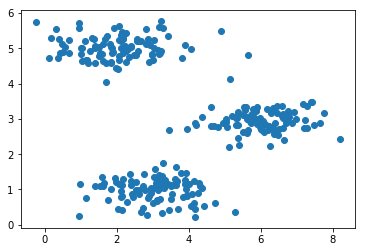

In [6]:
plt.scatter(x[:, 0], x[:, 1])
plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [7]:
def find_closest_centroids(x, centroids):
    idx = np.zeros(len(x))
    
    for i in range(len(x)):
        diff = x[i] - centroids
        idx[i] = np.argmin(np.sum(np.square(diff), 1))
        
    return idx.astype('int')

In [8]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = find_closest_centroids(x, initial_centroids)

print('Closest centroids for the first 3 examples: {}'.format(idx[:3]))

Closest centroids for the first 3 examples: [0 2 1]


In [9]:
def compute_centroids(x, idx, k):
    centroids = np.zeros((k, x.shape[1]))
    
    for i in range(k):
        centroid_idx = (idx == i).reshape(-1, 1)
        centroids[i] = np.sum(x * centroid_idx, 0) / np.sum(centroid_idx)
        
    return centroids

In [10]:
k = 3
centroids = compute_centroids(x, idx, k)
print('Centroids computed after initial finding of closest centroids:\n{}'.format(centroids))

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


In [11]:
def kmeans(x, initial_centroids, max_iter):
    centroids = initial_centroids
    k = len(initial_centroids)
    
    for i in range(max_iter):
        idx = find_closest_centroids(x, centroids)
        centroids = compute_centroids(x, idx, k)
        
    return centroids, idx

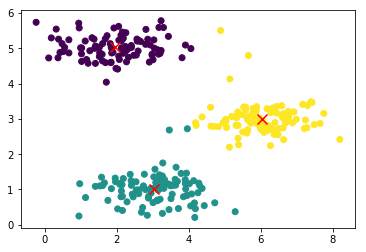

In [12]:
centroids, idx = kmeans(x, initial_centroids, max_iter=10)
plt.scatter(x[:, 0], x[:, 1], c=idx)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='r', s=100)

plt.savefig(figsdir / 'clusters.png', bbox_inches='tight')

## Image compression

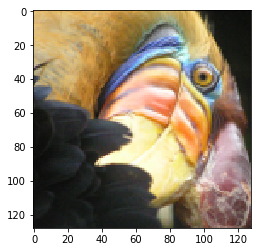

In [13]:
image = imread(datadir / 'bird_small.png', pilmode='RGB')
imshow(image)
image = image / 255
image = image.reshape(-1, 3)

In [14]:
def init_centroids(x, k):
    idx_perm = np.random.permutation(len(x))
    return x[idx_perm[:k], :]

In [15]:
# Run K-means

k = 16
max_iters = 10
initial_centroids = init_centroids(image, k)
centroids, idx = kmeans(image, initial_centroids, max_iters)

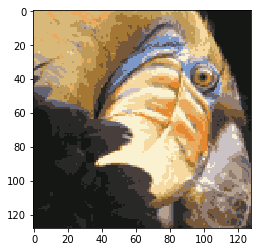

In [16]:
# Visualize compressed image

compressed_image = centroids[idx, :].reshape(128, 128, 3)
compressed_image = (compressed_image * 255).astype('int')
imshow(compressed_image)

plt.savefig(figsdir / 'compressed_image.png', bbox_inches='tight')

# Principal Component Analysis

## Example dataset

In [17]:
data = loadmat(datadir / 'ex7data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [18]:
x = data['X']
print('x: {}'.format(x.shape))

x: (50, 2)


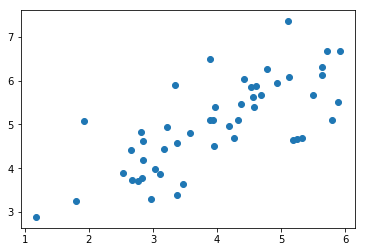

In [19]:
plt.scatter(x[:, 0], x[:, 1])
plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [20]:
def feature_normalize(x):
    mu = x.mean(axis=0)
    sigma = x.std(axis=0, ddof=1)
    x_norm = np.divide(x - mu, sigma)
    
    return x_norm, mu, sigma

In [21]:
def pca(x):
    cov_matrix = x.T.dot(x) / len(x)
    u, s, _ = np.linalg.svd(cov_matrix)
    
    return u, s

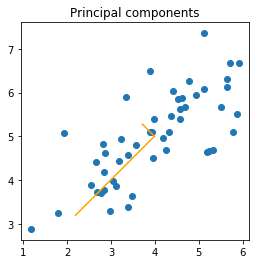

In [22]:
x_norm, mu, sigma = feature_normalize(x)
u, s = pca(x_norm)

plt.gca().set_aspect('equal')
plt.scatter(x[:, 0], x[:, 1])
plt.plot([mu[0], mu[0] + 1.5*s[0]*u[0,0]], [mu[1], mu[1] + 1.5*s[0]*u[0,1]], c='orange')
plt.plot([mu[0], mu[0] + 1.5*s[1]*u[1,0]], [mu[1], mu[1] + 1.5*s[1]*u[1,1]], c='orange')
plt.title('Principal components')

plt.savefig(figsdir / 'principal_components.png', bbox_inches='tight')

In [23]:
def project_data(x, u, k):
    return x.dot(u[:, :k])

In [24]:
def recover_data(z, u, k):
    return z.dot(u[:, :k].T)

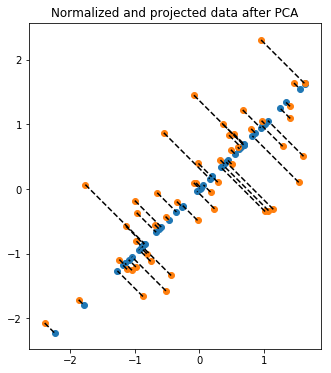

In [25]:
# Project the data onto k=1 dimension
z = project_data(x_norm, u, k=1)

# Recover the data
x_rec = recover_data(z, u, k=1)

plt.figure().set_size_inches(6, 6)
plt.gca().set_aspect('equal')

plt.scatter(x_rec[:, 0], x_rec[:, 1])
plt.scatter(x_norm[:, 0], x_norm[:, 1])
for i in range(len(x_norm)):
    plt.plot([x_norm[i, 0], x_rec[i, 0]], [x_norm[i, 1], x_rec[i, 1]], '--k')
    
plt.title('Normalized and projected data after PCA')

plt.savefig(figsdir / 'projected_data.png')

## Face image dataset

In [26]:
data = loadmat(datadir / 'ex7faces.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [27]:
x = data['X']
x.shape

(5000, 1024)

In [28]:
def display_data(x):
    n = np.sqrt(x.shape[0]).astype('int')
    cols = np.sqrt(x.shape[1]).astype('int')
    img = np.zeros((n, n*cols, cols))
    
    for i in range(n):
        in_idx = n * i
        fin_idx = n * (i + 1)
        img[i] = x[in_idx:fin_idx].reshape(-1, cols)
        
    img = np.concatenate([img[i] for i in range(n)], axis=1)
    
    plt.figure().set_size_inches(6, 6)
    plt.imshow(img.T)

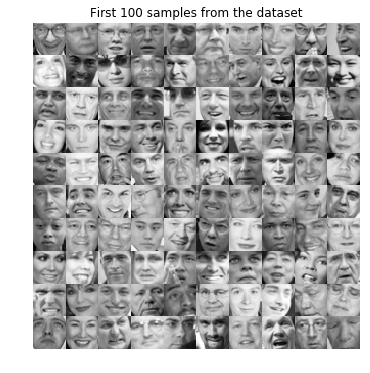

In [29]:
display_data(x[:100])
plt.title('First 100 samples from the dataset')
plt.set_cmap('Greys_r')
plt.axis('off')

plt.savefig(figsdir / 'faces.png', bbox_inches='tight')

In [30]:
# Normalize and run PCA

x_norm, mu, sigma = feature_normalize(x)
u, s = pca(x_norm)

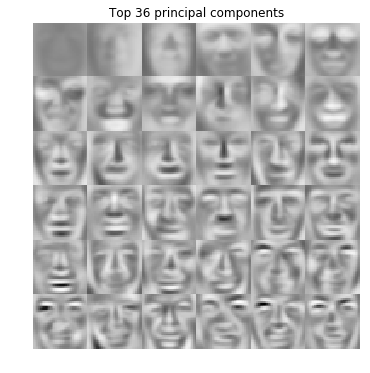

In [31]:
display_data(u[:, :36].T)
plt.title('Top 36 principal components')
plt.set_cmap('Greys_r')
plt.axis('off')

plt.savefig(figsdir / 'principal_components_faces.png', bbox_inches='tight')

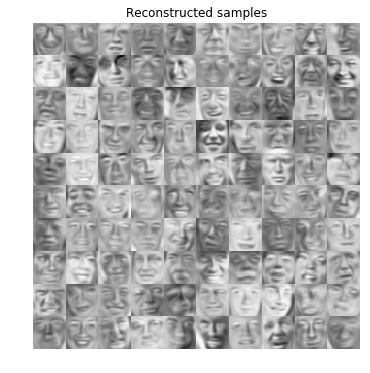

In [32]:
# Project and reconstruct the data

k = 100
z = project_data(x_norm, u, k)
x_rec = recover_data(z, u, k)

display_data(x_rec[:100])
plt.title('Reconstructed samples')
plt.set_cmap('Greys_r')
plt.axis('off')

plt.savefig(figsdir / 'reconstructed_faces.png', bbox_inches='tight')

# PCA for visualization

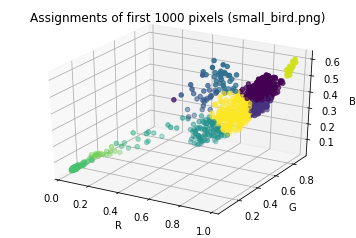

In [33]:
sel = 1000
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(image[:sel, 0], image[:sel, 1], image[:sel, 2], c=idx[:sel], cmap='viridis')
ax.set_title('Assignments of first 1000 pixels (small_bird.png)')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.savefig(figsdir / 'pixel_assignments_3d.png', bbox_inches='tight')

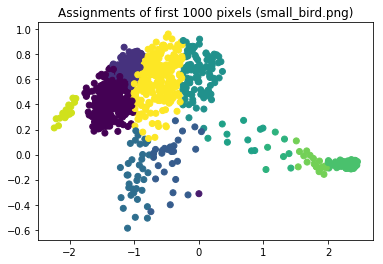

In [34]:
image_norm, mu, sigma = feature_normalize(image)
u, s = pca(image_norm)
z = project_data(image_norm, u, k=2)
#z.shape, idx.shape
plt.scatter(z[:sel, 0], z[:sel, 1], c=idx[:sel], cmap='viridis')
plt.title('Assignments of first 1000 pixels (small_bird.png)')

plt.savefig(figsdir / 'pixel_assignments_2d.png', bbox_inches='tight')